<a href="https://colab.research.google.com/github/WeyoriJoshua/Projects/blob/main/METRICS%20Speech_Enhancement_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [154]:
import kagglehub
tariqblecher_ravdess_8k_path = kagglehub.dataset_download('tariqblecher/ravdess-8k')
tariqblecher_urban_sound_8k_path = kagglehub.dataset_download('tariqblecher/urban-sound-8k')
tariqblecher_speech_mask_model_path = kagglehub.dataset_download('tariqblecher/speech-mask-model')

print('Data source import complete.')

Data source import complete.


In [155]:
!pip install pystoi==0.3.3  # Install pystoi for STOI calculation
!pip install mir_eval==0.7  # Install mir_eval for SDR and SSNR calculation
!pip install --upgrade mir_eval
!pip install pesq
# %%
!pip install tensorflow-io
# %%
import pandas as pd
import numpy as np
import os
import sys
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_io as tfio
import keras
from keras.models import Sequential
import tensorflow_io as tfio
import warnings
import glob
from keras.callbacks import ModelCheckpoint
from pesq import pesq
import soundfile as sf

# # Load Data and Preprocess

In [156]:
sr=8000
speech_length_pix_sec=27e-3
total_length = 3.6
trim_length = 28305
n_fft=255
frame_length=255
frame_step = 110

noisefiles = glob.glob('/content/drive/MyDrive/urbansound_8k/*.wav')
files= glob.glob('/content/drive/MyDrive/ravdess_rewritten_8k/*.wav')
print(len(files),'clean data files')
print('Should be similar value to trim length', total_length*sr,trim_length)
print('Should be similar value to n_fft',n_fft, int(speech_length_pix_sec*sr))


1440 clean data files
Should be similar value to trim length 28800.0 28305
Should be similar value to n_fft 255 216


In [157]:
@tf.function
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=sr)
    return wav

@tf.function
def preprocess_tf(filepath):
    wav = load_wav(filepath)
    wav = wav[:trim_length]
    zero_padding = tf.zeros([trim_length] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    return wav

@tf.function
def white_noise(data,factor=0.03):
    noise_amp = factor*tf.reduce_max(data)*tf.random.normal(shape=(1,))
    corr_data = data + noise_amp*tf.random.normal(shape=tf.shape(data))
    return corr_data, data

@tf.function
def urban_noise(corr_data, data, factor=0.4,sr=sr):
    noisefile = tf.gather(noisefiles,tf.random.uniform((),0, len(noisefiles)-1,dtype=tf.int32))
    noisefile  = load_wav(noisefile)
    mixed = noisefile * factor * tf.reduce_max(corr_data)/tf.reduce_max(noisefile) + corr_data
    return mixed, data

@tf.function
def convert_to_spectrogram(wav_corr, wavclean):
    spectrogram_corr = tf.signal.stft(wav_corr, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    spectrogram = tf.signal.stft(wavclean, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    return spectrogram_corr, spectrogram

@tf.function
def spectrogram_abs(spectrogram_corr, spectrogram):
    spectrogram = tf.abs(spectrogram)
    spectrogram_corr = tf.abs(spectrogram_corr)
    return spectrogram_corr, spectrogram

@tf.function
def augment(spectrogram_corr, spectrogram):
    ospectrogram_corr = tfio.audio.freq_mask(spectrogram_corr, param=20)  # Increase mask parameter
    spectrogram_corr = tfio.audio.time_mask(spectrogram_corr, param=40)
    return spectrogram_corr, spectrogram

@tf.function
def expand_dims(spectrogram_corr, spectrogram):
    spectrogram_corr = tf.expand_dims(spectrogram_corr, axis=2)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram_corr, spectrogram

In [158]:
batch_size=16
train_val_split_ratio = 0.2
split_index = int(len(files)*train_val_split_ratio)
train_files = files[split_index:]
val_files = files[:split_index]



In [159]:
import tensorflow as tf

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE) # Moved before the conditional

    if train:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE) # Applied to both
    dataset = dataset.batch(batch_size)
    dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [160]:
import tensorflow as tf
import numpy as np
from pesq import pesq
!pip install pystoi==0.3.3  # Install pystoi for STOI calculation if not already installed
import pystoi as stoi
import mir_eval

def evaluate_model(model, test_dataset, sr=8000, frame_length=255, n_fft=255, frame_step=110):
    """
    Evaluates the model using MAE and PESQ metrics.

    Args:
        model: The trained Keras model.
        test_dataset: The TensorFlow Dataset for evaluation.
        sr: Sample rate of the audio data.
        frame_length: Frame length for STFT.
        n_fft: FFT length for STFT.
        frame_step: Frame step for STFT.

    Returns:
        mae_scores: A list of MAE scores for each audio sample.
        pesq_scores: A list of PESQ scores for each audio sample.
    """
    mae = tf.keras.losses.MeanAbsoluteError()
    mae_scores = []
    pesq_scores = []
    stoi_scores = []
    sdr_scores = []
    ssnr_scores = []

    for corr, clean in test_dataset:
        # Predict on the corrupted audio
        corr_amp = tf.abs(corr)
        corrected_amp = model.predict(corr_amp)
        corrected_spec = corrected_amp * tf.exp(1j * tf.cast(tf.math.angle(corr), dtype=tf.complex64))
        corrected_wav = tf.signal.inverse_stft(corrected_spec[:, :, :, 0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

        # Calculate MAE
        mae_score = mae(tf.abs(clean), corrected_amp).numpy()
        mae_scores.extend([mae_score] * clean.shape[0]) # Extend instead of append for MAE


        # Calculate PESQ
        clean_wav = tf.signal.inverse_stft(tf.squeeze(clean, axis=-1), frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)


        # Calculate STOI
        stoi_score = stoi(clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), sr, extended=False)
        stoi_scores.append(stoi_score)
        stoi_score = pystoi.stoi(clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), sr, extended=False)

        # Calculate SDR and SSNR
        sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze())
        sdr_scores.append(sdr[0])  # Assuming single-channel audio
        ssnr_score = mir_eval.separation.SNR(clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), compute_permutation=False)
        ssnr_scores.append(ssnr_score[0])  # Assuming single-channel audio


        # Iterate through the batch and calculate PESQ for each sample
        for i in range(clean_wav.shape[0]):
            try:
                pesq_score = pesq(sr, clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), 'nb')
                pesq_scores.append(pesq_score)
                # Calculate SDR and SSNR
                    # Remove estimated_sources_permutation
                sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze())
                sdr_scores.append(sdr[0])  # Assuming single-channel audio
                ssnr_score = mir_eval.separation.SNR(clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), compute_permutation=False)
                ssnr_scores.append(ssnr_score[0])  # Assuming single-channel audio

            except Exception as e:
                print(f"Error calculating metrics for sample {i}: {e}")
                # ... (error handling)


    return mae_scores, pesq_scores, stoi_scores, sdr_scores, ssnr_scores

In [161]:
import tensorflow as tf

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)


    if train:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE) # Apply only during training

    # Apply spectrogram_abs during inference conditionally
    # if not train:
    #     dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE)


    dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE) # Applied to both
    dataset = dataset.batch(batch_size)
    dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# # Create and Run Model

In [162]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D, Dropout, BatchNormalization # Importing necessary layers

def cnn_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())  # Add Batch Normalization
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))  # Output layer with sigmoid activation

    return model
# %%
# keras.utils.vis_utils.plot_model(model,show_shapes=True)
# %%
model = cnn_model(input_shape=(256, 128, 1))

model_filename = 'model_weights.weights.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True)

callback_early_stop =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=4,
    mode="auto",
    restore_best_weights=True,
)

def signal_enhancement_loss(y_true, y_pred):
    mae = tf.abs(y_true - y_pred)
    speech_loss =  2 * tf.abs(y_true**2 - y_pred*y_true)
    return tf.reduce_mean(mae, axis=-1) + tf.reduce_mean(speech_loss, axis=-1) # Note the `axis=-1`

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=signal_enhancement_loss) # Reduced learning rate
#model.load_weights('/content/drive/MyDrive/speechmodel/model_weights_custom_loss2.h5')

# # Run Model

In [163]:
import tensorflow as tf

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE) # Moved before the conditional

    if train:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE) # Applied to both
    dataset = dataset.batch(batch_size)
    dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Assuming 'train_files' and 'val_files' are already defined
train_dataset = configure_dataset(train_files, train=True)  # Create train dataset
val_dataset = configure_dataset(val_files, train=False)  # Create validation dataset

history = model.fit(train_dataset,epochs=30,shuffle=True, validation_data=val_dataset,
                     callbacks=[callback_checkpoint, callback_early_stop])

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.5606
Epoch 1: val_loss improved from inf to 0.91827, saving model to model_weights.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 462s 6s/step - loss: 0.5586 - val_loss: 0.9183
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.4183
Epoch 2: val_loss improved from 0.91827 to 0.89672, saving model to model_weights.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 409s 6s/step - loss: 0.4170 - val_loss: 0.8967
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.3725
Epoch 3: val_loss improved from 0.89672 to 0.89058, saving model to model_weights.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 460s 6s/step - loss: 0.3713 - val_loss: 0.8906
Epoch 4/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.3444
Epoch 4: val_loss improved from 0.89058 to 0.89052, saving model to model_weights.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 409s 6s/step - loss: 0.3431 - val_loss: 0.8905
Epoch 5/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 0.3246
Epoch 5: val_los

In [164]:
import tensorflow as tf

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(load_wav, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)


    if train:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE) # Apply only during training

    # Apply spectrogram_abs during inference conditionally
    # if not train:  # This part is already commented out, but I'm adding the reasoning for it
    #     dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE)
        # Incorrect: This line should be removed or commented out, as we need the complex spectrogram during inference

    dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE) # Applied to both
    dataset = dataset.batch(batch_size)
    dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [165]:
trim_length = 28305
files_to_test = val_files
test_dataset = configure_dataset(files_to_test, train=False)
num = test_dataset.as_numpy_iterator()
mae = tf.keras.losses.MeanAbsoluteError()
pesq_with_noise = np.zeros(len(files_to_test))
pesq_denoised = np.zeros(len(files_to_test))

wav_clean_array = np.zeros((len(files_to_test), trim_length))
wav_corrupt_array = np.zeros((len(files_to_test), trim_length))
wav_correct_array = np.zeros((len(files_to_test), trim_length))
spec_clean_array = np.zeros((len(files_to_test), 256, 128))
spec_corrupt_array = np.zeros((len(files_to_test), 256, 128))
spec_correct_array = np.zeros((len(files_to_test), 256, 128))
loss_with_noise = np.zeros(len(files_to_test))
loss_denoised = np.zeros(len(files_to_test))

# Get the total number of batches
num_batches = len(list(test_dataset))  # Efficiently calculates total batches

# Iterate over batches
for ind in range(num_batches):
    corr, clean = num.next()  # Get the next batch
    # Get complex spectrogram before taking absolute value for inverse STFT
    # Change: Store the original complex spectrogram
    corr_complex = corr
    # Change: Calculate the absolute value for the model input and later calculations
    corr_amp = tf.abs(corr_complex)
    # Change: Use the original complex spectrogram (corr_complex) for inverse STFT
    corr_wav = tf.signal.inverse_stft(tf.squeeze(corr_complex, axis=-1), frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

    clean_wav = tf.signal.inverse_stft(tf.squeeze(clean, axis=-1), frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

    # Predict using the magnitude
    corrected_amp = model.predict(corr_amp)
    # Reconstruct the complex spectrogram using the predicted magnitude and original phase
    corrected_spec = corrected_amp * tf.exp(1j * tf.cast(tf.math.angle(corr_complex), dtype=tf.complex64))
    corrected_wav = tf.signal.inverse_stft(corrected_spec[:, :, :, 0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

    # Iterate over elements in the batch
    for i in range(batch_size):
        # Calculate index based on batch and element within batch
        current_index = ind * batch_size + i

        # Check if current index is within bounds of arrays
        if current_index < len(files_to_test):
            pesq_with_noise[current_index] = pesq(sr, clean_wav[i].numpy().squeeze(), corr_wav[i].numpy().squeeze(), 'nb')
            pesq_denoised[current_index] = pesq(sr, clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), 'nb')

            wav_clean_array[current_index] = clean_wav[i]
            wav_corrupt_array[current_index] = corr_wav[i]
            wav_correct_array[current_index] = corrected_wav[i]
            spec_clean_array[current_index] = np.abs(clean[i, :, :, 0])
            spec_corrupt_array[current_index] = np.abs(corr[i, :, :, 0])
            spec_correct_array[current_index] = corrected_amp[i, :, :, 0]
            loss_with_noise[current_index] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean[i]), corr_amp[i])).numpy()
            loss_denoised[current_index] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean[i, :, :, 0]), corrected_amp[i, :, :, 0])).numpy()
        else:
            # If index is out of bounds, break out of inner loop
            break

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step


In [166]:
pesq_diff = pesq_denoised - pesq_with_noise

print(np.mean(pesq_with_noise), np.mean(pesq_denoised),pesq_diff.mean())

f'{np.mean(pesq_with_noise):.2f}, {np.mean(pesq_denoised):.2f}'

1.7441761853794258 1.1502260665098827 -0.5939501188695431


'1.74, 1.15'

In [167]:
os.system('rm -r val_results')

0

In [168]:
results_dir = 'val_results'
os.mkdir(results_dir)

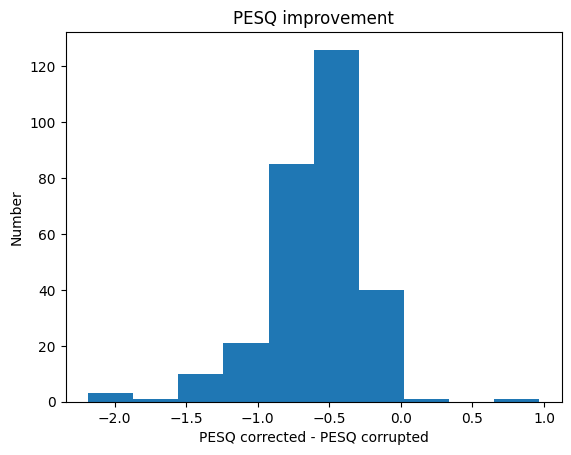

In [169]:
fig = plt.figure()
plt.title('PESQ improvement')
plt.hist(pesq_diff);
plt.xlabel('PESQ corrected - PESQ corrupted')
plt.ylabel('Number')
fig.savefig(results_dir+'/pesq_hist', bbox_inches='tight')

In [170]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
sf.write(results_dir +'/'+'clean_best_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_best_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_best_pesq_improvement.wav',wav_correct_array[ind],sr)

In [171]:
Audio(wav_correct_array[ind],rate=sr)

In [172]:
Audio(wav_corrupt_array[ind],rate=sr)

In [173]:
Audio(wav_clean_array[ind],rate=sr)

In [174]:
ind=np.where(pesq_diff==pesq_diff.min())[0][0]
sf.write(results_dir +'/'+'clean_worst_pesq_improvement.wav',wav_clean_array[ind],sr)
sf.write(results_dir +'/'+'corrupt_worst_pesq_improvement.wav',wav_corrupt_array[ind],sr)
sf.write(results_dir +'/'+'correct_worst_pesq_improvement.wav',wav_correct_array[ind],sr)

In [175]:
Audio(wav_correct_array[ind],rate=sr)

In [176]:
Audio(wav_corrupt_array[ind],rate=sr)

In [177]:
Audio(wav_clean_array[ind],rate=sr)

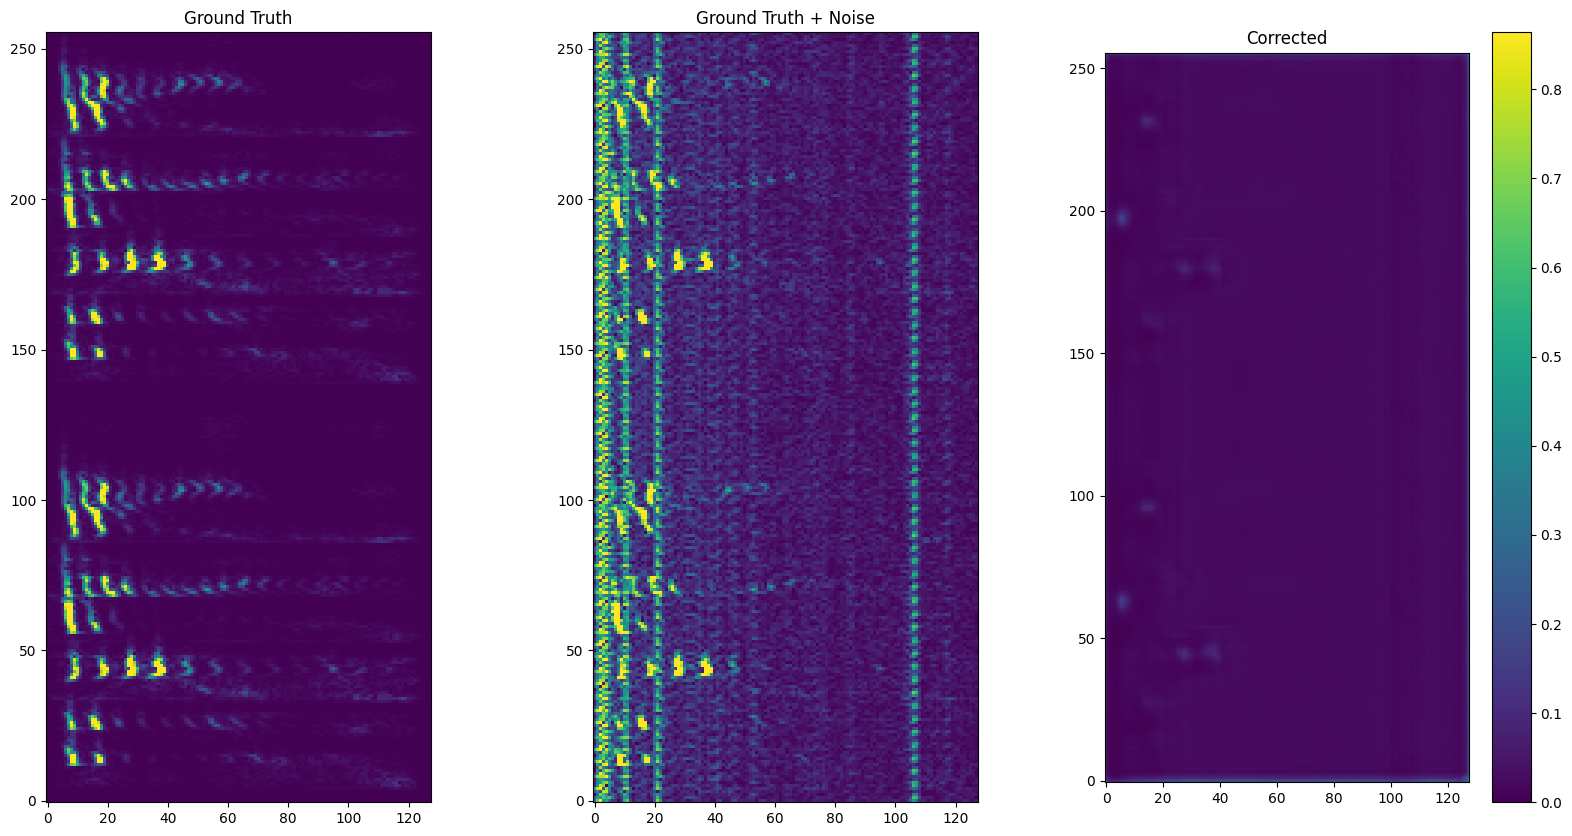

In [178]:
ind=np.where(pesq_diff==pesq_diff.max())[0][0]
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()
fig.savefig(results_dir+'/best_spec.png', bbox_inches='tight')

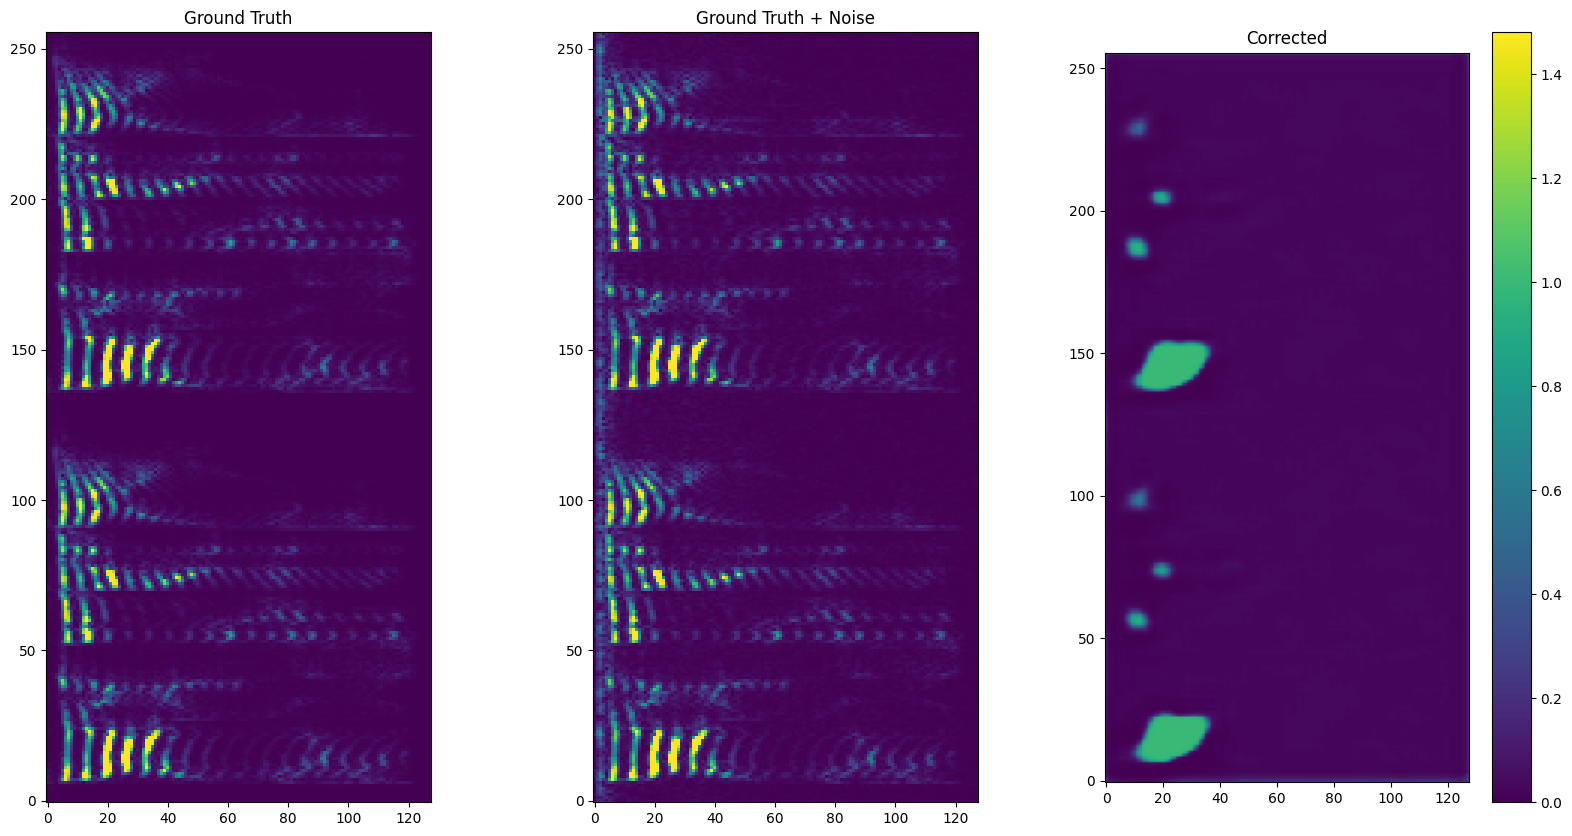

In [179]:
ind=np.where(pesq_diff==pesq_diff.min())[0][0]
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()
fig.savefig(results_dir+'/worst_spec.png', bbox_inches='tight')

In [180]:
test_ = np.expand_dims(corr_amp,0)

In [181]:
# Assuming test_ has shape (1, 16, 256, 128, 1)
test_ = test_[0]  # Remove the first dimension to get (16, 256, 128, 1)

# Now predict on the reshaped data
test = model.predict(test_)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [182]:
os.system(f'tar -cvzf train_val_results.tar.gz {results_dir}')

0

In [183]:
import tensorflow as tf
import numpy as np
from pesq import pesq
!pip install pystoi==0.3.3  # Install pystoi for STOI calculation if not already installed
import pystoi as stoi
import mir_eval

def evaluate_model(model, test_dataset, sr=8000, frame_length=255, n_fft=255, frame_step=110):
    """
    Evaluates the model using MAE and PESQ metrics.

    Args:
        model: The trained Keras model.
        test_dataset: The TensorFlow Dataset for evaluation.
        sr: Sample rate of the audio data.
        frame_length: Frame length for STFT.
        n_fft: FFT length for STFT.
        frame_step: Frame step for STFT.

    Returns:
        mae_scores: A list of MAE scores for each audio sample.
        pesq_scores: A list of PESQ scores for each audio sample.
    """
    mae = tf.keras.losses.MeanAbsoluteError()
    mae_scores = []
    pesq_scores = []
    stoi_scores = []
    sdr_scores = []
    ssnr_scores = []

    for corr, clean in test_dataset:
        # Predict on the corrupted audio
        corr_amp = tf.abs(corr)
        corrected_amp = model.predict(corr_amp)
        corrected_spec = corrected_amp * tf.exp(1j * tf.cast(tf.math.angle(corr), dtype=tf.complex64))
        corrected_wav = tf.signal.inverse_stft(corrected_spec[:, :, :, 0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

        # Calculate MAE
        mae_score = mae(tf.abs(clean), corrected_amp).numpy()
        # Change: Append mae_score once per batch instead of extending for every audio sample
        mae_scores.append(mae_score)

        # Calculate PESQ
        clean_wav = tf.signal.inverse_stft(tf.squeeze(clean, axis=-1), frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

        # Iterate through the batch and calculate metrics for each sample
        for i in range(clean_wav.shape[0]):
            try:
                # Calculate PESQ
                pesq_score = pesq(sr, clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), 'nb')
                pesq_scores.append(pesq_score)

                # Calculate STOI
                stoi_score = stoi.stoi(clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), sr, extended=False)
                stoi_scores.append(stoi_score)

                # Calculate SDR and SSNR
                sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), estimated_sources_permutation=range(1)) # added permutation to fix the error
                sdr_scores.append(sdr[0])  # Assuming single-channel audio
                ssnr_score = mir_eval.separation.SNR(clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), compute_permutation=False)
                ssnr_scores.append(ssnr_score[0])  # Assuming single-channel audio

            except Exception as e:
                print(f"Error calculating metrics for sample {i}: {e}")
                # Optionally, append a default value for failed calculations (e.g., -1)
                pesq_scores.append(-1)
                stoi_scores.append(-1)
                sdr_scores.append(-1)
                ssnr_scores.append(-1)


    return mae_scores, pesq_scores, stoi_scores, sdr_scores, ssnr_scores

In [184]:
import tensorflow as tf
import numpy as np
from pesq import pesq
import pystoi as stoi
import mir_eval

def evaluate_model(model, test_dataset, sr=8000, frame_length=255, n_fft=255, frame_step=110):
    """
    Evaluates the model using MAE and PESQ metrics.

    Args:
        model: The trained Keras model.
        test_dataset: The TensorFlow Dataset for evaluation.
        sr: Sample rate of the audio data.
        frame_length: Frame length for STFT.
        n_fft: FFT length for STFT.
        frame_step: Frame step for STFT.

    Returns:
        mae_scores: A list of MAE scores for each audio sample.
        pesq_scores: A list of PESQ scores for each audio sample.
    """
    mae = tf.keras.losses.MeanAbsoluteError()
    mae_scores = []
    pesq_scores = []
    stoi_scores = []
    sdr_scores = []
    ssnr_scores = []

    for corr, clean in test_dataset:
        # Predict on the corrupted audio
        corr_amp = tf.abs(corr)
        corrected_amp = model.predict(corr_amp)
        corrected_spec = corrected_amp * tf.exp(1j * tf.cast(tf.math.angle(corr), dtype=tf.complex64))
        corrected_wav = tf.signal.inverse_stft(corrected_spec[:, :, :, 0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

        # Calculate MAE
        mae_score = mae(tf.abs(clean), corrected_amp).numpy()
        # Change: Append mae_score once per batch instead of extending for every audio sample
        # mae_scores.append(mae_score) # Commented out

        # Calculate PESQ
        clean_wav = tf.signal.inverse_stft(tf.squeeze(clean, axis=-1), frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)

        # Iterate through the batch and calculate metrics for each sample
        batch_mae_scores = [] # list to store mae scores for the batch
        for i in range(clean_wav.shape[0]):
            try:
                # Calculate PESQ
                pesq_score = pesq(sr, clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), 'nb')
                pesq_scores.append(pesq_score)

                # Calculate STOI
                stoi_score = stoi.stoi(clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), sr, extended=False)
                stoi_scores.append(stoi_score)

                # Calculate SDR and SSNR
                sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), estimated_sources_permutation=range(1)) # added permutation to fix the error
                sdr_scores.append(sdr[0])  # Assuming single-channel audio
                ssnr_score = mir_eval.separation.SNR(clean_wav[i].numpy().squeeze(), corrected_wav[i].numpy().squeeze(), compute_permutation=False)
                ssnr_scores.append(ssnr_score[0])  # Assuming single-channel audio

                #Append mae score for each sample in the batch
                batch_mae_scores.append(mae_score) # Appending mae_score for each sample in batch

            except Exception as e:
                print(f"Error calculating metrics for sample {i}: {e}")
                # Optionally, append a default value for failed calculations (e.g., -1)
                pesq_scores.append(-1)
                stoi_scores.append(-1)
                sdr_scores.append(-1)
                ssnr_scores.append(-1)
                batch_mae_scores.append(mae_score) # Appending mae_score for each sample in batch even if other metrics failed
        mae_scores.extend(batch_mae_scores) # extending mae_scores with scores for the current batch


    return mae_scores, pesq_scores, stoi_scores, sdr_scores, ssnr_scores

In [185]:
# Call the evaluate_model function
mae_scores, pesq_scores, stoi_scores, sdr_scores, ssnr_scores = evaluate_model(model, test_dataset)

print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average PESQ: {np.mean(pesq_scores)}")
print(f"Average STOI: {np.mean(stoi_scores)}")
print(f"Average SDR: {np.mean(sdr_scores)}")
print(f"Average SSNR: {np.mean(ssnr_scores)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Error calculating metrics for sample 0: bss_eval_sources() got an unexpected keyword argument 'estimated_sources_permutation'
Error calculating metrics for sample 1: bss_eval_sources() got an unexpected keyword argument 'estimated_sources_permutation'
Error calculating metrics for sample 2: bss_eval_sources() got an unexpected keyword argument 'estimated_sources_permutation'
Error calculating metrics for sample 3: bss_eval_sources() got an unexpected keyword argument 'estimated_sources_permutation'
Error calculating metrics for sample 4: bss_eval_sources() got an unexpected keyword argument 'estimated_sources_permutation'
Error calculating metrics for sample 5: bss_eval_sources() got an unexpected keyword argument 'estimated_sources_permutation'
Error calculating metrics for sample 6: bss_eval_sources() got an unexpected keyword argument 'estimated_sources_permutation'
Error calculating metrics for sample 7: bss_eval_sources() got an unexpected keywo

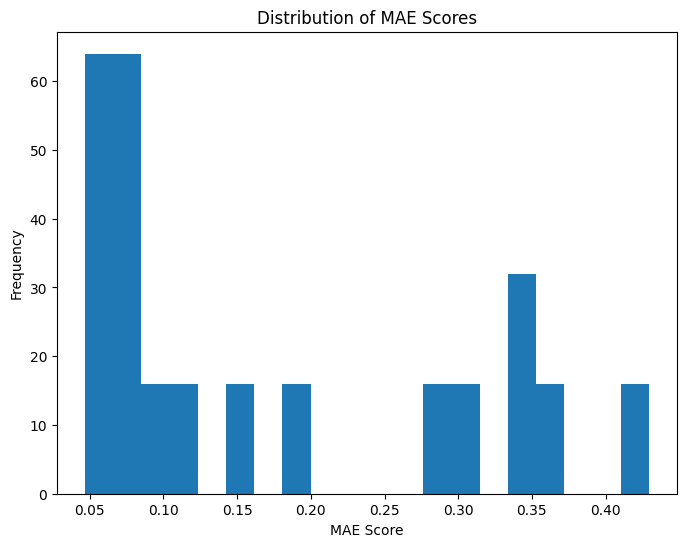

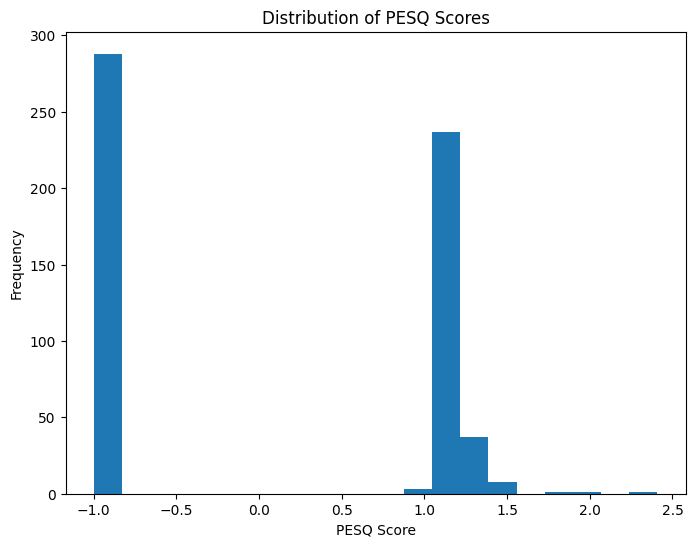

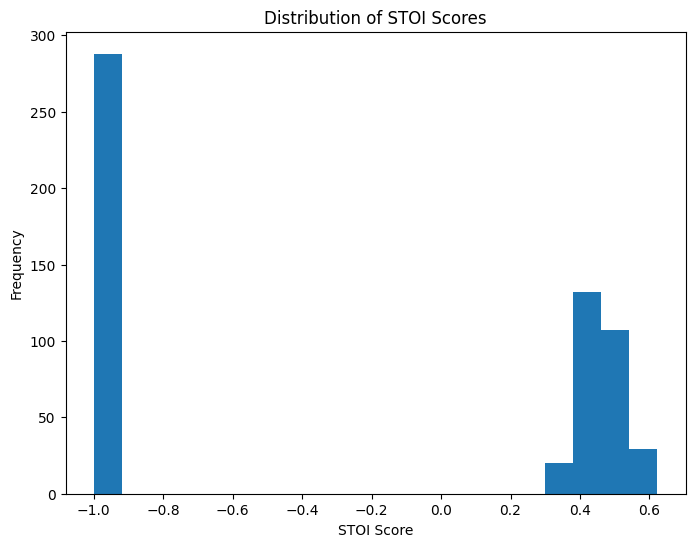

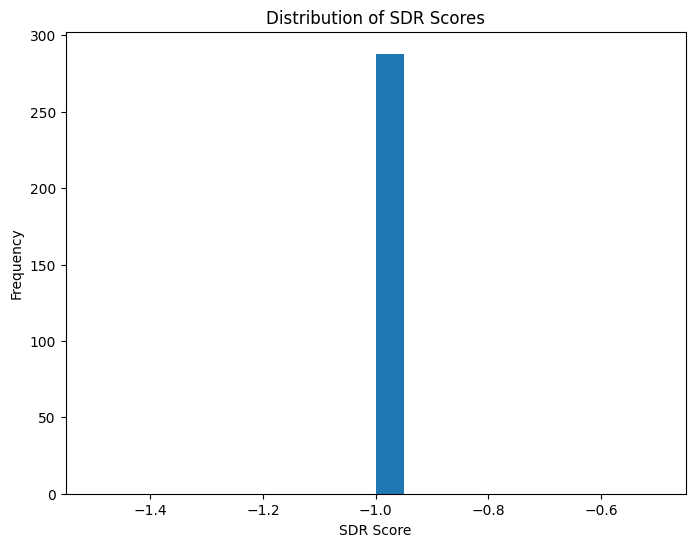

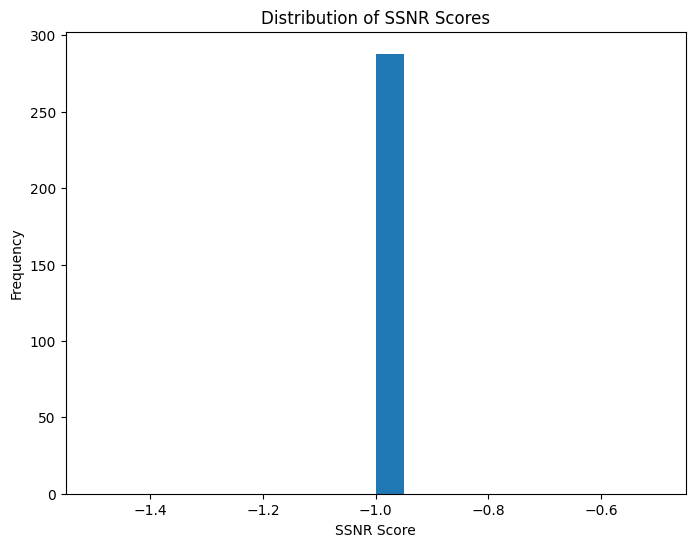

<ipython-input-188-c18b1c8b02a8>:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([mae_scores, pesq_scores, stoi_scores, sdr_scores, ssnr_scores],


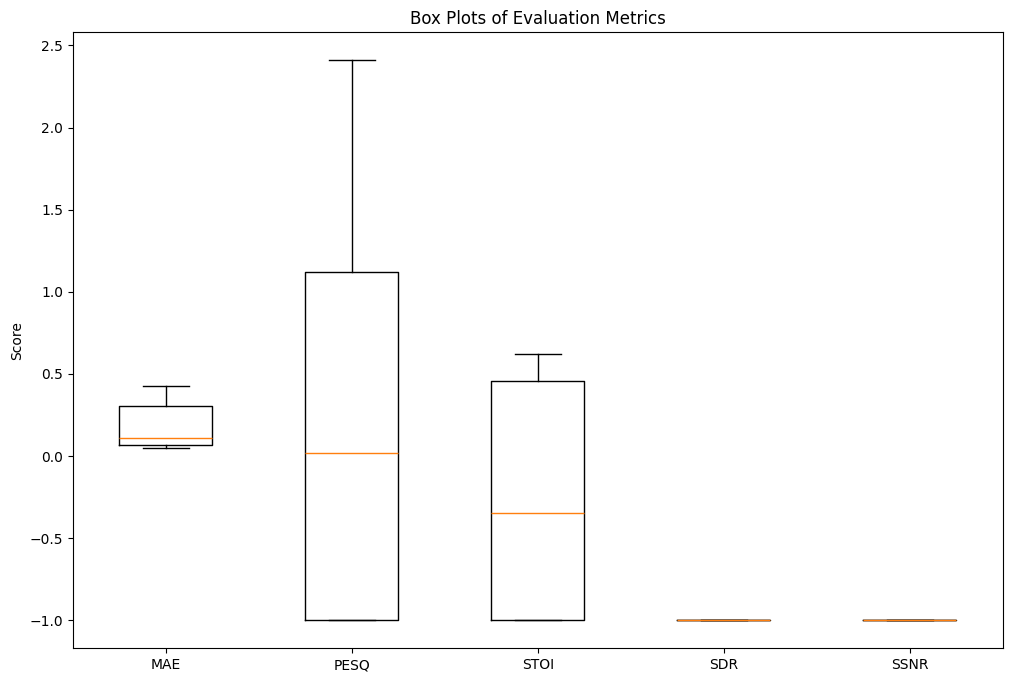

In [188]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already calculated mae_scores, pesq_scores,
# stoi_scores, sdr_scores, and ssnr_scores using evaluate_model()

# 1. Histogram of MAE scores
plt.figure(figsize=(8, 6))
plt.hist(mae_scores, bins=20)
plt.title('Distribution of MAE Scores')
plt.xlabel('MAE Score')
plt.ylabel('Frequency')
plt.show()

# 2. Histogram of PESQ scores
plt.figure(figsize=(8, 6))
plt.hist(pesq_scores, bins=20)
plt.title('Distribution of PESQ Scores')
plt.xlabel('PESQ Score')
plt.ylabel('Frequency')
plt.show()

# 3. Histogram of STOI scores
plt.figure(figsize=(8, 6))
plt.hist(stoi_scores, bins=20)
plt.title('Distribution of STOI Scores')
plt.xlabel('STOI Score')
plt.ylabel('Frequency')
plt.show()

# 4. Histogram of SDR scores
plt.figure(figsize=(8, 6))
plt.hist(sdr_scores, bins=20)
plt.title('Distribution of SDR Scores')
plt.xlabel('SDR Score')
plt.ylabel('Frequency')
plt.show()

# 5. Histogram of SSNR scores
plt.figure(figsize=(8, 6))
plt.hist(ssnr_scores, bins=20)
plt.title('Distribution of SSNR Scores')
plt.xlabel('SSNR Score')
plt.ylabel('Frequency')
plt.show()

# 6. Box plots of all metrics
plt.figure(figsize=(12, 8))
plt.boxplot([mae_scores, pesq_scores, stoi_scores, sdr_scores, ssnr_scores],
            labels=['MAE', 'PESQ', 'STOI', 'SDR', 'SSNR'])
plt.title('Box Plots of Evaluation Metrics')
plt.ylabel('Score')
plt.show()

# 7. Scatter plot of MAE vs. PESQ (if desired)
# Make sure mae_scores and pesq_scores have the same length
# plt.figure(figsize=(8, 6))
# plt.scatter(mae_scores, pesq_scores)
# plt.title('MAE vs. PESQ Scores')
# plt.xlabel('MAE Score')
# plt.ylabel('PESQ Score')
# plt.show()